用keras自带的函数每次换机器要下载很麻烦

自己参照源代码修改了以下，可以直接读取本地的cifar10

In [9]:
import matplotlib.pyplot as plt  
import numpy as np
import os
import sys
from six.moves import cPickle
import keras.backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

In [15]:
def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = cPickle.load(f)
    else:
        d = cPickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_data(path):
    """
    # data should have be unzip in this path
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    num_train_samples = 50000
    
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data(path = r'F:/data/cifar10/')  
print('finish loading data')
print(X_train.shape, y_train.shape)

finish loading data
(50000, 32, 32, 3) (50000, 1)


In [16]:
y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)
print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


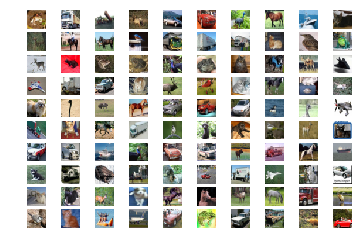

In [11]:
plt.figure(facecolor='white')  
  
for i in range(100):   
    plt.subplot(10, 10, i+1)  
    plt.imshow(X_train[i])  
    plt.axis("off")  
  
plt.show() 

In [ ]:

#把数据变成float32更精确
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model = Sequential()

# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=1,
         verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, batch_size=32,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 261s - loss: 2.0322 - acc: 0.2436 - val_loss: 1.6430 - val_acc: 0.4037


In [ ]:
from keras.models import load_model
import h5py
#需要先pip install cython  再安装h5py  这里才可以运行

model.save('my_model_cifar10.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model2 = load_model('my_model_cifar10.h5')

In [ ]:
# import matplotlib.pyplot as plt # plt 用于显示图片
# import matplotlib.image as mpimg # mpimg 用于读取图片
# import numpy as np

# def simglePre(path):
#     img = mpimg.imread(path) # 读取和代码处于同一目录下的 lena.png
#     # 此时img就已经是一个 np.array 了，可以对它进行任意处理
#     from scipy import misc
#     small_img = misc.imresize(img, (28,28)) # 第二个参数如果是整数，则为百分比，如果是tuple，则为输出图像的尺寸
#     def rgb2gray(rgb):
#         return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
#     gray = rgb2gray(small_img)    
#     plt.imshow(gray,cmap='Greys_r') # 显示图片
#     plt.axis('off') # 不显示坐标轴
#     plt.show()

#     x_single = gray
#     x_single = x_single.reshape(1,28,28,1)
#     return np.argmax(model2.predict(x_single, batch_size=1, verbose=0))


# print(simglePre(r'F:\data\mnist\3.png'))
# print(simglePre(r'F:\data\mnist\8.png'))